# ARIMA, SARIMAX and AutoARIMA

**ARIMA** (AutoRegressive Integrated Moving Average) and its extension **SARIMAX** (Seasonal AutoRegressive Integrated Moving Average with eXogenous estimators) are prominent and widely used statistical forecasting models.

In the ARIMA-SARIMAX model notation, the parameters $p$, $d$, and $q$ represent the **autoregressive**, **differencing**, and **moving-average** components, respectively. $P$, $D$, and $Q$ denote the same components for the **seasonal** part of the model, with $m$ representing the number of periods in each season.

+ $p$ is the order (number of time lags) of the **autoregressive** part of the model.

+ $d$ is the degree of **differencing** (the number of times that past values have been subtracted from the data).

+ $q$ is the order of the **moving average** part of the model.

+ $P$ is the order (number of time lags) of the **seasonal** part of the model.

+ $D$ is the degree of **seasonal differencing** (the number of times the data have had past values subtracted) of the seasonal part of the model.

+ $Q$ is the order of the **seasonal moving average** of the seasonal part of the model.

+ $m$ refers to the **number of periods in each season**.

When the terms $P$, $D$, $Q$, and $m$ are zero and no exogenous variables are included in the model, the SARIMAX model is equivalent to an ARIMA.

When two out of the three terms are zero, the model can be referred to based on the non-zero parameter, dropping "AR", "I" or "MA" from the acronym describing the model. For example, $ARIMA(1,0,0)$ is $AR(1)$, $ARIMA(0,1,0)$ is $I(1)$, and $ARIMA(0,0,1)$ is $MA(1)$.

<font size="6">ARIMA implementations</font>

**Skforecast** provides two classes that allow the creation of ARIMA family models:

+ [skforecast Sarimax](../api/stats.html#skforecast.stats._sarimax.Sarimax): A **wrapper for statsmodels SARIMAX** that strictly follows the scikit-learn API. Similar to pmdarima, this version has been streamlined to include only the essential elements required by skforecast, resulting in significant performance improvements.

+ [skforecast Arima](../api/stats.html#skforecast.stats._arima.Arima): A **native implementation** that also follows the scikit-learn API. This version is **optimized for speed** using Numba JIT compilation. It supports seasonal components, exogenous features, and automated parameter searching, making it a versatile tool for the entire ARIMA family: **ARIMA**, **SARIMAX**, and **AutoARIMA**.

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.stats import Arima, Sarimax
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.utils import expand_index
from skforecast.plot import set_dark_theme, plot_prediction_intervals
import warnings

warnings.filterwarnings('once')
# Ignore DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=False)
data = data.loc[:'1990-01-01 00:00:00', ['Gasolinas']]
data = data.rename(columns={'Gasolinas': 'y'})
data.index.name = 'datetime'
data.head(4)

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 5 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

,y
datetime,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164


Train dates : 1969-01-01 00:00:00 --- 1983-01-01 00:00:00  (n=169)
Test dates  : 1983-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=84)


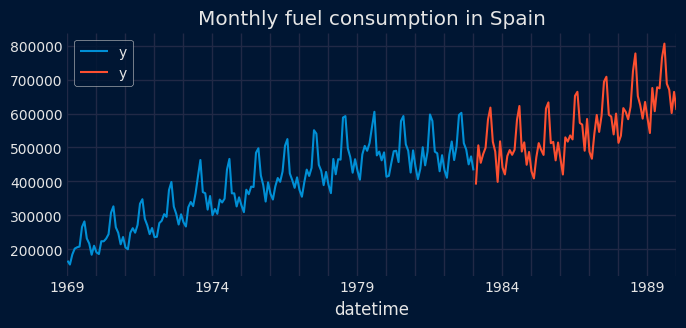

In [ ]:
# Split data in train-test partitions
# ======================================================================================
end_train = '1983-01-01 23:59:59'

print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

## Model definition and training

This section shows how to create and train ARIMA models using each of the two classes available in skforecast.

In [4]:
# ARIMA model with skforecast wrapper of statsmodels
# ==============================================================================
model = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train['y'])
model

,order,"(1, ...)"
,seasonal_order,"(1, ...)"
,trend,None
,measurement_error,False
,time_varying_regression,False
,mle_regression,True
,simple_differencing,False
,enforce_stationarity,True
,enforce_invertibility,True
,hamilton_representation,False
,concentrate_scale,False


In [5]:
# Model summary
# ==============================================================================
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  169
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1765.688
Date:                            Sun, 01 Feb 2026   AIC                           3541.375
Time:                                    11:23:09   BIC                           3556.625
Sample:                                01-01-1969   HQIC                          3547.569
                                     - 01-01-1983                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3524      0.143     -2.470      0.014      -0.632      -0.073
ma.L1         -0.1970      0.145     -1.358      0.174      -0.481       0.087
ar.S.L12       0.0509      0.109      0.465      0.642      -0.164       0.265
ma.S.L12      -0.4676      0.140     -3.333      0.001      -0.743      -0.193
sigma2      3.962e+08   3.32e-10   1.19e+18      0.000    3.96e+08    3.96e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.98   Jarque-Bera (JB):                14.14
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.49
Prob(H) (two-sided):                  0.72   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+33. Standard errors may be unstable.
"""

In [6]:
# ARIMA model with skforecast Arima class
# ==============================================================================
model = Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12)
model.fit(y=data_train['y'])
model

c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\skforecast\stats\arima\_arima_base.py:2521: UserWarning: Possible convergence problem. Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


,order,"(1, ...)"
,seasonal_order,"(1, ...)"
,m,12
,include_mean,True
,transform_pars,True
,method,'CSS-ML'
,n_cond,None
,SSinit,'Gardner1980'
,optim_method,'BFGS'
,optim_kwargs,{'maxiter': 1000}
,kappa,1000000.0


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>
Skforecast's ARIMA implementation is optimized for speed using just-in-time compilation with Numba. This makes that the first fit of the model is slower due to the compilation process, but subsequent fits and predictions are significantly faster compared to the statsmodels implementation.
</p>
</div>

In [7]:
# Model summary
# ==============================================================================
model.summary()

ARIMA Model Summary
Model     : Arima(1,1,1)(1,1,1)[12]
Method    : ARIMA(1,1,1)(1,1,1)[12]
Converged : False

Coefficients:
------------------------------------------------------------
  ar1            :    -0.3082  (SE:   0.1137, t:    -2.71)
  ma1            :    -0.5584  (SE:   0.1093, t:    -5.11)
  sar1           :    -0.1389  (SE:   0.1160, t:    -1.20)
  sma1           :    -0.5582  (SE:   0.1010, t:    -5.53)

Model fit statistics:
  sigma^2:             249192709.810593
  Log-likelihood:      -1733.55
  AIC:                 3477.11
  BIC:                 N/A

Residual statistics:
  Mean:                -1167.526626
  Std Dev:             15166.476134
  MAE:                 10860.457801
  RMSE:                15166.543437

Time Series Summary Statistics:
Number of observations: 169
  Mean:                 384743.1773
  Std Dev:              108126.6689
  Min:                  155466.8105
  25%:                  303667.7591
  Median:               397278.0241
  75%:            

The following sections of this document utilize the native `skforecast.stats.Arima` implementation, as it offers superior performance for real-world use cases and it also implements the auto-arima process.

## Prediction

Once the model is fitted, it can be used to forecast future observations. It is important to note that these types of models **require predictions to follow immediately after the training data**; therefore, the forecast starts right after the last observed value.

In [8]:
# Predictions
# ==============================================================================
steps = len(data_test)
predictions = model.predict(steps=steps)
predictions[:5]

array([414755.65708567, 465102.49379062, 504458.85873736, 472054.36369183,
       494879.12878838])

For performance reasons, predictions are returned as **NumPy arrays**. These can be easily converted into **Pandas Series** by mapping them to the corresponding time index.

In [9]:
# Predictions as pandas Series
# ==============================================================================
pred_index = expand_index(index=data_train.index, steps=steps)
predictions = pd.Series(predictions, index=pred_index)
predictions.head(4)

1983-02-01    414755.657086
1983-03-01    465102.493791
1983-04-01    504458.858737
1983-05-01    472054.363692
Freq: MS, dtype: float64

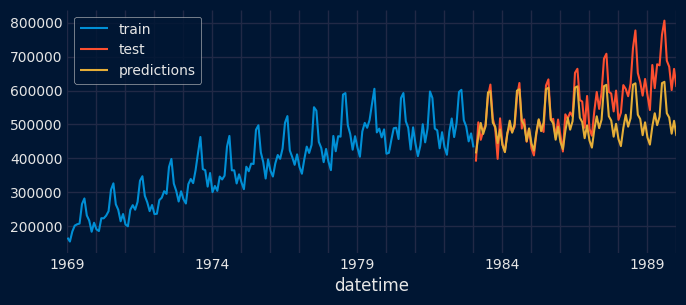

In [10]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [11]:
# Prediction error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mae): {error_mae}")

Test error (mae): 59203.058715250874


## Prediction intervals

The method `predict_interval` enables the calculation of **prediction intervals** for the forecasted values. Users can specify the **confidence level** of the estimated interval using either the `alpha` or `interval` argument.

In [12]:
# Prediction intervals
# ==============================================================================
predictions = model.predict_interval(steps=steps, alpha=0.05)
predictions.index = pred_index
predictions.head(3)

,mean,lower_95,upper_95
1983-02-01,414755.657086,383541.980897,445969.333274
1983-03-01,465102.493791,431519.674752,498685.312829
1983-04-01,504458.858737,469463.167098,539454.550376


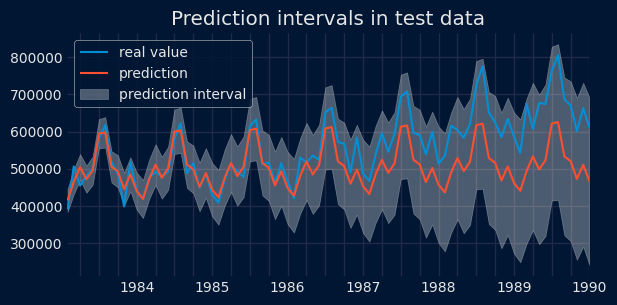

In [13]:
# Plot prediction intervals
# ==============================================================================
preds_to_plot = predictions.copy()
preds_to_plot = preds_to_plot.rename(
    columns={'mean': 'pred', 'lower_95': 'lower_bound', 'upper_95': 'upper_bound'}
)

fig, ax = plt.subplots(figsize=(6, 3))
plot_prediction_intervals(
    predictions         = preds_to_plot,
    y_true              = data_test,
    target_variable     = "y",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'white', 'alpha': 0.3, 'zorder': 1},
    ax                  = ax
)

## Feature importances

For the ARIMA model, the method `get_feature_importances` returns the **estimated coefficients** of the model (AR, MA, and seasonal components). These coefficients indicate the weight assigned to each lag term in the model's equations.

In [14]:
# Feature importances
# ==============================================================================
model.get_feature_importances()

,feature,importance
0,ar1,-0.308182
1,ma1,-0.558438
2,sar1,-0.138924
3,sma1,-0.558172


## AutoArima

**AutoArima** is an algorithm designed to **automate the selection of optimal hyperparameters** for an ARIMA model. The algorithm systematically evaluates various combinations of non-seasonal parameters ($p, d, q$), seasonal parameters ($P, D, Q$), and the seasonal period ($m$) to identify the configuration that best fits the data based on a specified criterion, typically the **Akaike Information Criterion (AIC)** or **Bayesian Information Criterion (BIC)**.

With this strategy, calculations are based **solely on training data**, eliminating the need for a separate data partition required by other strategies such as [grid search](../user_guides/hyperparameter-tuning-and-lags-selection.html). This makes the optimization process extremely efficient. However, it is important to note that information criteria only measure the **relative quality** of models within the defined search space. A model with the lowest AIC could still be a poor fit in absolute terms. Therefore, the selected model should ideally undergo a **backtesting phase**. This phase calculates forecast error metrics (such as MAE, MSE, or MAPE) to validate performance on a meaningful, interpretable scale.

Skforecast's [Arima](./forecasting-sarimax-arima.html) class triggers the AutoArima functionality whenever the `order` or `seasonal_order` arguments are set to `None`. After the model is fitted, the optimal parameters can be accessed via the `best_params_` attribute. For all subsequent predictions, the model automatically utilizes the optimal configuration identified during the fitting process.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

When evaluating ARIMA-SARIMAX models, it is important to note that AIC assumes that all models are trained on the same data. Thus, using AIC to decide between different orders of differencing is technically invalid, since one data point is lost with each order of differencing. Therefore, the Auto Arima algorithm uses a <b>unit root test</b> to select the order of differencing, and only uses the AIC to select the order of the AR and MA components.

For a detailed explanation of Akaike's Information Criterion (AIC) see <a href="https://robjhyndman.com/hyndsight/aic/">Rob J Hyndman's blog</a> and <a href="https://sites.warnercnr.colostate.edu/kenburnham/wp-content/uploads/sites/25/2016/08/AIC-Myths-and-Misunderstandings.pdf">AIC Myths and Misunderstandings by Anderson and Burnham</a>.

</div>

In [15]:
# Skforecast Auto Arima
# ==============================================================================
auto_arima = Arima(
    order          = None,  # Must be None to use AutoArima
    seasonal_order = None,  # Must be None to use AutoArima
    start_p        = 0,
    start_q        = 0,
    max_p          = 5,
    max_q          = 5,
    max_P          = 5,
    max_Q          = 2,
    max_order      = 5,
    max_d          = 2,
    max_D          = 1,
    ic             = "aic",
    m              = 12,
    stepwise       = True,  # True for faster results
    trace          = True,  # True for detailed information of the process
)
auto_arima.fit(y=data_train['y'], suppress_warnings=True)
auto_arima


Fitting models using approximations...

 ARIMA(p,d,q)(P,D,Q)[m]                     : aic
 ------------------------------------------------
 ARIMA(0,1,0)(1,1,1)[12]                    : 3564.3887
 ARIMA(0,1,0)(0,1,0)[12]                    : 3637.1363
 ARIMA(1,1,0)(1,1,0)[12]                    : 3506.9117
 ARIMA(0,1,1)(0,1,1)[12]                    : 3481.3432
 ARIMA(0,1,1)(0,1,0)[12]                    : 3542.1014
 ARIMA(0,1,1)(1,1,1)[12]                    : 3482.0043
 ARIMA(0,1,1)(0,1,2)[12]                    : 3481.2735
 ARIMA(0,1,1)(1,1,2)[12]                    : 3482.5762
 ARIMA(0,1,0)(0,1,2)[12]                    : 3563.7959
 ARIMA(1,1,1)(0,1,2)[12]                    : 3476.4900
 ARIMA(1,1,1)(0,1,1)[12]                    : 3476.4887
 ARIMA(1,1,1)(0,1,0)[12]                    : 3531.8215
 ARIMA(1,1,1)(1,1,1)[12]                    : 3477.1082
 ARIMA(1,1,1)(1,1,0)[12]                    : 3493.3277
 ARIMA(1,1,1)(1,1,2)[12]                    : 3478.4277
 ARIMA(1,1,0)(0,1,1

,order,None
,seasonal_order,None
,m,12
,include_mean,True
,transform_pars,True
,method,'CSS-ML'
,n_cond,None
,SSinit,'Gardner1980'
,optim_method,'BFGS'
,optim_kwargs,{'maxiter': 1000}
,kappa,1000000.0


In [16]:
# Predictions
# ==============================================================================
steps = len(data_test)
predictions = auto_arima.predict(steps=steps)
pred_index = expand_index(index=data_train.index, steps=steps)
predictions = pd.Series(predictions, index=pred_index)
predictions.head(4)

1983-02-01    416655.426668
1983-03-01    469422.816846
1983-04-01    505800.991887
1983-05-01    474452.122359
Freq: MS, dtype: float64

Test error (mae): 53517.26243040556


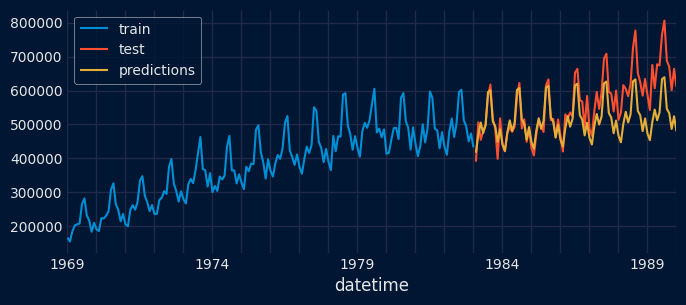

In [17]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

# Prediction error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mae): {error_mae}")

## Exogenous variables

The addition of **exogenous variables** is done using the `exog` argument. The only requirement for including an exogenous variable is the need to **know the value of the variable also during the forecast period**.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about exogenous variables and how to correctly manage them with skforecast visit: <a href="../user_guides/exogenous-variables.html">Exogenous variables (features) user guide</a>.

</div>

In [18]:
# Create calendar features to be used as exogenous variables
# ==============================================================================
data_exog = data.assign(month=data.index.month)
data_exog_train = data_exog.loc[:end_train]
data_exog_test  = data_exog.loc[end_train:]
data_exog.head()

,y,month
datetime,,
1969-01-01,166875.2129,1
1969-02-01,155466.8105,2
1969-03-01,184983.6699,3
1969-04-01,202319.8164,4
1969-05-01,206259.1523,5


In [19]:
# Create and fit model with exogenous variables
# ==============================================================================
model = Arima(order=(1, 1, 1), seasonal_order=(0, 1, 1), m=12)
model.fit(
    y                 = data_exog_train['y'], 
    exog              = data_exog_train['month'],
    suppress_warnings = True
)

# Predict with exog
# ==============================================================================
predictions = model.predict(
                  steps = steps,
                  exog  = data_exog_test['month']
              )
pred_index = expand_index(index=data_exog_train.index, steps=steps)
predictions = pd.Series(predictions, index=pred_index)
predictions.head(3)

1983-02-01    416655.260667
1983-03-01    469422.814528
1983-04-01    505798.127366
Freq: MS, dtype: float64

## In-sample Predictions

**In-sample predictions** are crucial for evaluating the accuracy and effectiveness of the model. By comparing the predicted values with the actual observed values in the training dataset, you can assess how well the model has learned the underlying patterns and trends in the data. This comparison helps in understanding the model's performance and identifying areas where it may need improvement or adjustment. In essence, they act as a mirror, reflecting how the model interprets and reconstructs the historical data on which it was trained.

Predictions of the observations used to fit the model are stored in the `fitted_values_` attribute of the `Arima` object.

In [20]:
# Create and fit Arima model (skforecast)
# ==============================================================================
model = Arima(order=(1, 1, 1), seasonal_order=(0, 1, 1), m=12)
model.fit(y=data_train['y'], suppress_warnings=True)

# In-sample Predictions
# ==============================================================================
# Show only the first 5 values 
model.fitted_values_[:5]

array([166778.86748706, 155441.28198656, 184949.38956605, 202282.72293588,
       206228.03030339])

## Backtesting

In time series forecasting, the process of [backtesting](./backtesting.html) consists of evaluating the performance of a predictive model by **applying it retrospectively to historical data**. To utilize the backtesting functionalities offered by skforecast with ARIMA models, the model must be used as an estimator within a [`ForecasterStats`](./forecasting-statistical-models.html) object.

<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:400;">
  <span style="margin-right:6px; font-size:18px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0 ; color:inherit;">
<b>Why do statistical models require refitting during backtesting?</b>
</p>

<p>
Unlike machine learning models, statistical models like ARIMA maintain an internal state that depends on the sequence of observations. They can only generate predictions starting from the last observed time step — they cannot "jump" to an arbitrary point in the future without knowing all previous values.

During backtesting, when the validation window moves forward, the model must be refitted to incorporate the new observations and update its internal state. This is why <code>refit=True</code> is typically required.

<b>Performance optimization:</b> Because refitting is mandatory, skforecast's Numba-optimized backend becomes essential. It enables hundreds of refits during backtesting in a fraction of the time required by non-optimized libraries.

<b>Exception:</b> The <code>skforecast.stats.Sarimax</code> model implements an efficient state-space representation that allows updating predictions without full model refitting.
</p>

</div>

In [21]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterStats(estimator=Arima(order=(1, 1, 1), seasonal_order=(0, 1, 1), m=12))
forecaster

=============== 
ForecasterStats 
=============== 
Estimators: ['skforecast.Arima'] 
Series name: None 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Estimator parameters: 
    skforecast.Arima: 
        {'order': (1, 1, 1), 'seasonal_order': (0, 1, 1), 'm': 12, 'include_mean':
        True, 'transform_pars': True, 'method': 'CSS-ML', 'n_cond': None,
        'SSinit': 'Gardner1980', 'optim_method': 'BFGS', 'optim_kwargs':
        {'maxiter': 1000}, 'kappa': 1000000.0} 
fit_kwargs: None 
Creation date: 2026-02-01 11:23:38 
Last fit date: None 
Index seen by the forecaster: None 
Skforecast version: 0.20.0 
Python version: 3.13.11 
Forecaster id: None

In [22]:
# Backtest forecaster
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 12,  # predict 12 month per fold
         initial_train_size = len(data_train),
         refit              = True,
         fixed_train_size   = False,
     )

metric, predictions = backtesting_stats(
                          forecaster        = forecaster,
                          y                 = data['y'],
                          cv                = cv,
                          metric            = 'mean_absolute_error',
                          n_jobs            = 'auto',
                          suppress_warnings = True,
                          verbose           = True,
                          show_progress     = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 169
Number of observations used for backtesting: 84
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02-01 00:00:00 -- 1985-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1985-01-01 00:00:00  (n=193)
    Validation: 1985-02-01 00:00:00 -- 1986-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1986-01-01 00:00:00  (n=205)
    Validation: 1986-02-01 00:00:00 -- 1987-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1987-01-01 00:00:00  (n=217)
    Validation: 1987-02-0

  0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
# Backtest predictions
# ==============================================================================
predictions.head(3)

,fold,pred
1983-02-01,0,416655.426668
1983-03-01,0,469422.816846
1983-04-01,0,505800.991887


In [24]:
# Backtesting metrics
# ==============================================================================
metric

,mean_absolute_error
0,19002.124041


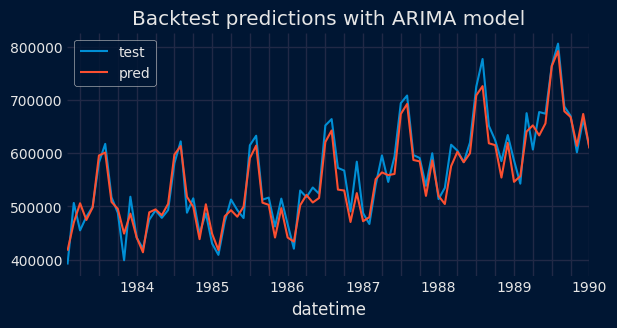

In [25]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

## Using an already trained ARIMA

Forecasting with an ARIMA model becomes challenging when the forecast horizon data **does not immediately follow the last observed value** during the training phase. This complexity is due to the **moving average (MA) component**, which relies on past forecast errors as predictors. Thus, to predict at time 't', the error of the 't-1' prediction becomes a necessity. In situations where this prediction isn't available, the corresponding error remains unavailable.

For this reason, in most cases, **ARIMA models are retrained each time predictions need to be made**. Despite considerable efforts and advances to speed up the training process for these models, it is not always feasible to retrain the model between predictions, either due to time constraints or insufficient computational resources for repeated access to historical data. An intermediate approach is to feed the model with data from the last training observation to the start of the prediction phase. This technique enables the estimation of intermediate predictions and, as a result, the necessary errors.

For example, imagine a situation where a model was trained 20 days ago with daily data from the past three years. When generating new predictions, **only the 20 most recent values would be needed**, rather than the complete historical dataset (365 * 3 + 20).

Integrating new data into the model can be complex, but the <code>ForecasterStats</code> class simplifies this considerably by automating the process through the `last_window` argument in its `predict` method.

<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:400;">
  <span style="margin-right:6px; font-size:18px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0; color:inherit;">

This section only applies when using <code>skforecast.stats.Sarimax</code>, since this implementation does not require predictions to start right after the training data.
</p>

</div>

Train dates       : 1969-01-01 00:00:00 --- 1983-01-01 00:00:00  (n=169)
Last window dates : 1983-02-01 00:00:00 --- 1988-01-01 00:00:00  (n=60)
Test dates        : 1988-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=24)


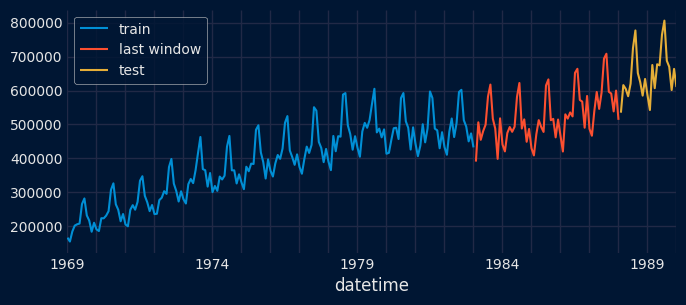

In [26]:
# Split data Train - Last window - Test
# ==============================================================================
end_train = '1983-01-01 23:59:59'
end_last_window = '1988-01-01 23:59:59'

print(
    f"Train dates       : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Last window dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_last_window].index.max()}  "
    f"(n={len(data.loc[end_train:end_last_window])})"
)
print(
    f"Test dates        : {data.loc[end_last_window:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_last_window:])})"
)

data_train       = data.loc[:end_train]
data_train       = data_train.assign(month=data_train.index.month)
data_last_window = data.loc[end_train:end_last_window]
data_last_window = data_last_window.assign(month=data_last_window.index.month)
data_test        = data.loc[end_last_window:]
data_test        = data_test.assign(month=data_test.index.month)

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_last_window['y'].plot(ax=ax, label='last window')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

Since exogenous variables have been included in the Forecaster training, it is necessary to pass both **past values** and their **future values** to the `predict` method using the `last_window_exog` and `exog` parameters when making predictions.

In [27]:
# Create and fit ForecasterStats with exogenous variables
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Sarimax(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
             )

forecaster.fit(
    y                 = data_train['y'], 
    exog              = data_train['month'],
    suppress_warnings = True
)

# Predict with exog and last window
# ==============================================================================
predictions = forecaster.predict(
                  steps            = len(data_test),
                  exog             = data_test['month'],
                  last_window      = data_last_window['y'],
                  last_window_exog = data_last_window['month']
              )
predictions.head(3)

1988-02-01    492215.252941
1988-03-01    570603.231908
1988-04-01    605183.045130
Freq: MS, Name: pred, dtype: float64

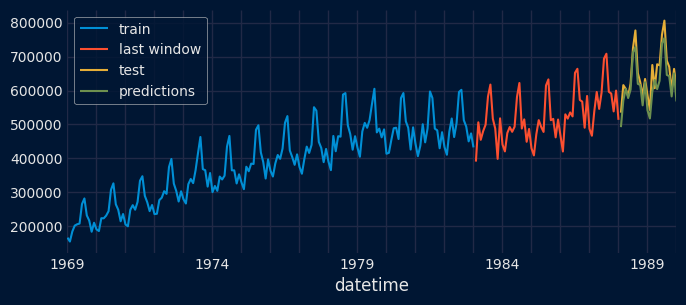

In [28]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_last_window['y'].plot(ax=ax, label='last window')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Memory optimization

For **production environments** where you need to store many fitted models but only require forecasting capabilities (not diagnostics), you can significantly **reduce memory usage** with the `reduce_memory()` method. This is especially useful when working with large datasets or deploying models in resource-constrained environments. This method removes **in-sample fitted values and residuals**, which are only needed for diagnostic purposes but not for generating forecasts.

In [29]:
# Compare size before and after reduce_memory()
# ==============================================================================
def total_model_size(model):
    size = sys.getsizeof(model)
    for attr_name in dir(model):
        if attr_name.startswith('_'):
            continue
        try:
            attr = getattr(model, attr_name)
            size += sys.getsizeof(attr)
        except Exception:
            pass
    return size


model = Arima(order=(1, 1, 1), seasonal_order=(0, 1, 1), m=12)
model.fit(y=data_train['y'])
model_size_before = total_model_size(model)
print(f"Memory before reduce_memory(): {model_size_before / 1024:.3f} KB")

# Reduce memory
model.reduce_memory()
model_size_after = total_model_size(model)
print(f"Memory after reduce_memory(): {model_size_after / 1024:.3f} KB")
print(f"Memory reduction: {(1 - model_size_after / model_size_before) * 100:.1f}%")

Memory before reduce_memory(): 6.812 KB
Memory after reduce_memory(): 3.843 KB
Memory reduction: 43.6%


c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\skforecast\stats\arima\_arima_base.py:2521: UserWarning: Possible convergence problem. Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\skforecast\stats\_arima.py:1129: UserWarning: Memory reduced. Diagnostic methods (get_residuals, get_fitted_values, summary, get_score) are no longer available. Prediction methods remain functional.
  warnings.warn(


In [30]:
# Predictions still work after memory reduction
# ==============================================================================
model.predict(steps=10)

array([416655.42666838, 469422.81684619, 505800.99188664, 474452.12235907,
       497942.38084899, 595506.08591244, 601114.39126818, 508378.57744427,
       495302.66156976, 448785.52529084])